In [16]:
import torch
print(torch.__version__)

2.4.1+cu121


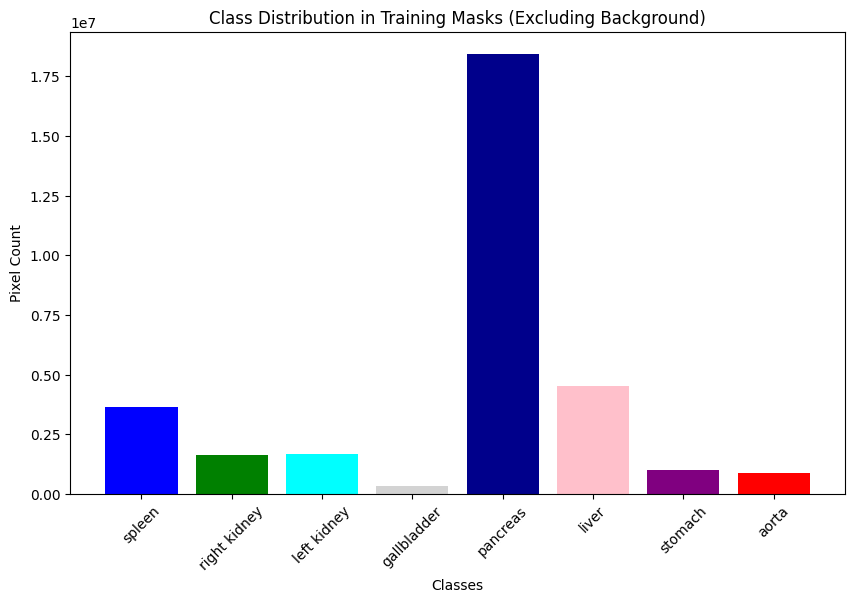

spleen: 3645277 pixels
right kidney: 1643210 pixels
left kidney: 1657491 pixels
gallbladder: 314044 pixels
pancreas: 18447950 pixels
liver: 4502312 pixels
stomach: 1011045 pixels
aorta: 883333 pixels


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the paths
train_masks_path = 'Groupproject/Dataset/train_masks'

# Define the number of classes based on your dataset (1-8) excluding background
num_classes = 8
class_names = ["spleen", "right kidney", "left kidney", "gallbladder", 
               "pancreas", "liver", "stomach", "aorta"]

# Initialize an array to store the count of each class, ignoring background
class_counts = np.zeros(num_classes, dtype=int)

# Process each mask file
for mask_file in os.listdir(train_masks_path):
    mask_path = os.path.join(train_masks_path, mask_file)
    if mask_file.endswith('.png'):  # Check if the file is a PNG
        mask = np.array(Image.open(mask_path))
        for i in range(1, num_classes + 1):  # Start from 1 to skip background (0)
            class_counts[i - 1] += np.sum(mask == i)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color=['blue', 'green', 'cyan', 'lightgray', 
                                          'darkblue', 'pink', 'purple', 'red'])
plt.xlabel("Classes")
plt.ylabel("Pixel Count")
plt.title("Class Distribution in Training Masks (Excluding Background)")
plt.xticks(rotation=45)
plt.show()

# Print the counts for each class
for i, count in enumerate(class_counts):
    print(f"{class_names[i]}: {count} pixels")


In [1]:
import os
import shutil
import random

# Define the paths to the folders
train_images_path = 'Groupproject/Dataset/train_images' 
train_masks_path = 'Groupproject/Dataset/train_masks'   

# Get the list of images and masks
train_images = sorted(os.listdir(train_images_path))
train_masks = sorted(os.listdir(train_masks_path))

# Ensure the number of images and masks is the same
assert len(train_images) == len(train_masks), "Mismatch between images and masks count."

# Check the total number of items
total_items = len(train_images)
print(f'Total items: {total_items}')

# Split the dataset
random.seed(42)
indices = list(range(total_items))
random.shuffle(indices)

# 8:2 split for training and validation sets
train_split = int(0.8 * total_items)

train_indices = indices[:train_split]
val_indices = indices[train_split:]

# Create folders for train and val splits
split_dirs = ['train', 'val']
for split in split_dirs:
    os.makedirs(f'Groupproject/{split}/images', exist_ok=True)
    os.makedirs(f'Groupproject/{split}/masks', exist_ok=True)

# Helper function to copy files to respective folders
def copy_files(indices, split_name):
    for idx in indices:
        image = train_images[idx]
        mask = train_masks[idx]
        shutil.copy(os.path.join(train_images_path, image), f'Groupproject/{split_name}/images/')
        shutil.copy(os.path.join(train_masks_path, mask), f'Groupproject/{split_name}/masks/')

# Copy files to train and val folders
copy_files(train_indices, 'train')
copy_files(val_indices, 'val')

print("Dataset split completed.")

# Check the number of files in each folder
def check_split_counts():
    for split in split_dirs:
        image_count = len(os.listdir(f'Groupproject/{split}/images'))
        mask_count = len(os.listdir(f'Groupproject/{split}/masks'))
        print(f'{split.capitalize()} Set: {image_count} images, {mask_count} masks')

# Check split counts
check_split_counts()


Total items: 1631
Dataset split completed.
Train Set: 1304 images, 1304 masks
Val Set: 327 images, 327 masks


loss function：FocalTverskyLoss

/tmp/ipykernel_3808514/854487659.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


Model weights loaded from Groupproject/SAM2_UNet_checkpoints/SAM2_UNet_final.pth
Predicted mask array:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


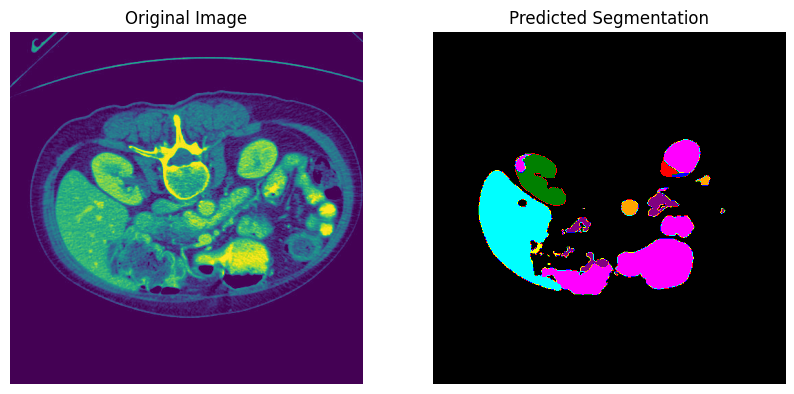

In [15]:
import os
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm


def test_single(model, image_path, device):
    """
    使用预训练模型对单个图像进行分割预测，并返回类别标签的 numpy 数组。
    
    Args:
        model: 预训练好的分割模型。
        image_path (str): 待预测图像的文件路径。
        device: 使用的设备（CPU 或 GPU）。
    
    Returns:
        np.ndarray: 预测的分割标签数组，形状为 (H, W)。
    """
    # 加载图像并预处理
    image = Image.open(image_path).convert('RGB')
    original_size = image.size  # 获取原始图像大小
    # image = image.resize((352, 352))  # 根据模型输入大小调整

    # 图像归一化和维度变换
    image = np.array(image) / 255.0
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    # 预测
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        pred_mask = output.argmax(dim=1).squeeze(0).cpu().numpy()

    # 将预测结果转换为 uint8 类型
    pred_mask = pred_mask.astype(np.uint8)

    # 将预测结果还原为原始图像大小
    pred_mask_resized = Image.fromarray(pred_mask).resize(original_size, resample=Image.NEAREST)
    pred_mask_resized = np.array(pred_mask_resized)

    return pred_mask_resized

def visualize_prediction(image_path, pred_mask):
    """
    可视化分割结果。
    
    Args:
        image_path (str): 输入图像路径。
        pred_mask (np.ndarray): 预测的分割掩码，类别标签数组。
    """
    # 定义类别颜色映射 (0-8)
    colors = ["black", "red", "green", "blue", "yellow", "cyan", "magenta", "orange", "purple"]
    cmap = mcolors.ListedColormap(colors[:np.max(pred_mask)+1])
    bounds = np.arange(-0.5, len(colors)+0.5, 1)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # 加载原始图像
    image = Image.open(image_path)

    # 绘图
    plt.figure(figsize=(10, 5))

    # 显示原始图像
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    # 显示分割掩码
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap=cmap, norm=norm)
    plt.title("Predicted Segmentation")
    plt.axis("off")

    plt.show()

# 使用示例
# 确保模型加载了权重
checkpoint_path = os.path.join(save_directory, "SAM2_UNet_final.pth")
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
print(f"Model weights loaded from {checkpoint_path}")

# 测试并可视化单张图像
test_image_path = "Groupproject/train_0000.png"  # 替换为实际图像路径
print("Predicted mask array:\n", predicted_mask)
predicted_mask = test_single(model, test_image_path, device)
visualize_prediction(test_image_path, predicted_mask)

In [1]:
import os
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

# 设置随机种子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 定义数据集类
class FullDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=352, limit=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])[:limit]
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])[:limit]
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        image = Image.open(image_path).convert('RGB').resize((self.image_size, self.image_size))
        mask = Image.open(mask_path).resize((self.image_size, self.image_size))

        image = np.array(image) / 255.0
        mask = np.array(mask)
        mask = np.clip(mask, 0, 8)   #发现有多于9个classes的mask,所以这里过滤掉
       
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.long)
        
        return {'image': image, 'label': mask}
        

# 定义模型
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class SAM2UNet(nn.Module):
    def __init__(self):
        super(SAM2UNet, self).__init__()
        self.encoder1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up1 = Up(1024 + 512, 512)
        self.up2 = Up(512 + 256, 256)
        self.up3 = Up(256 + 128, 128)
        self.up4 = Up(128 + 64, 64)
        self.head = nn.Conv2d(64, 9, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(self.pool1(x1))
        x3 = self.encoder3(self.pool2(x2))
        x4 = self.encoder4(self.pool3(x3))
        x5 = self.bottleneck(self.pool4(x4))
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.head(x)

# 定义 IoU 计算函数
def calculate_iou(pred_mask, true_mask, num_classes):
    pred_mask = pred_mask.argmax(dim=1)
    iou_list = []
    per_class_iou = {}
    for i in range(num_classes):
        intersection = ((pred_mask == i) & (true_mask == i)).sum().item()
        union = ((pred_mask == i) | (true_mask == i)).sum().item()
        iou = intersection / union if union != 0 else float('nan')
        iou_list.append(iou)
        per_class_iou[i] = iou
    mean_iou = np.nanmean(iou_list)
    return mean_iou, per_class_iou

# 定义评估函数
def evaluate(model, dataloader, device, num_classes=9):
    model.eval()
    metric_list = []
    per_class_iou_total = {i: [] for i in range(num_classes)}
    with torch.no_grad():
        for data in tqdm(dataloader):
            images = data['image'].to(device)
            masks = data['label'].to(device)
            outputs = model(images)
            mean_iou, per_class_iou = calculate_iou(outputs, masks, num_classes)
            for class_id, iou in per_class_iou.items():
                if not np.isnan(iou):
                    per_class_iou_total[class_id].append(iou)
            metric_list.append(mean_iou)
    avg_per_class_iou = {class_id: np.nanmean(iou_list) for class_id, iou_list in per_class_iou_total.items()}
    mean_iou = np.mean(metric_list)
    return mean_iou, avg_per_class_iou

# Define FocalTverskyLoss class
class FocalTverskyLoss(torch.nn.Module):
    def __init__(
        self,
        weight=None,
        size_average=True,
        alpha=0.6,
        beta=0.4,
        smooth=1,
        gamma=4 / 3,
        class_weights=None,
    ):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
        self.gamma = gamma
        self.class_weights = class_weights

        # Keep BG weight at 1
        if self.class_weights is not None:
            self.class_weights[-1] = 1.0

    def forward(self, inputs, targets):
        # Apply softmax to get probabilities
        inputs = F.softmax(inputs, dim=1)
        
        # One-hot encode the target mask
        num_classes = inputs.shape[1]
        targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2).float()

        # Flatten inputs and targets for calculation
        class_input = inputs.reshape(-1)
        class_target = targets_one_hot.reshape(-1)

        # True Positive, False Negative, False Positive
        TP = (class_input * class_target).sum()
        FP = ((1 - class_target) * class_input).sum()
        FN = (class_target * (1 - class_input)).sum()

        # Calculate Tversky Index
        Tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)

        # Calculate Focal Tversky Loss
        FocalTversky = (1 - Tversky) ** (1 / self.gamma)

        return FocalTversky


# Update the train_model function to use FocalTverskyLoss
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device, save_path="checkpoints"):
    os.makedirs(save_path, exist_ok=True)  # Create save directory

    # Initialize FocalTverskyLoss
    criterion = FocalTverskyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in train_loader:
            images = data['image'].to(device)
            masks = data['label'].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)  # Use FocalTverskyLoss
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

        # Evaluate on validation set
        model.eval()
        val_iou, val_per_class_iou = evaluate(model, val_loader, device)
        print(f"Validation Mean IoU: {val_iou:.4f}")
        print(f"Validation Per-class IoU: {val_per_class_iou}")

        # Save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(save_path, f"model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model saved at {checkpoint_path}")

    # Save final model weights
    final_model_path = os.path.join(save_path, "SAM2_UNet_final_FocalTverskyLoss.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")


# 设置保存的路径（如果需要保存到特定位置）
save_directory = "Groupproject/SAM2_UNet_checkpoints"  # 自定义路径

# 创建模型实例并加载保存的权重
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SAM2UNet().to(device)

# Define the path to the saved model checkpoint
checkpoint_path = os.path.join(save_directory, "SAM2_UNet_final.pth")  # 使用已保存的checkpoint

# 加载模型权重，避免重新训练
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print("Model loaded from", checkpoint_path)
else:
    print("Checkpoint not found, training from scratch.")

# 创建数据加载器
train_dataset = FullDataset('Groupproject/train/images', 'Groupproject/train/masks')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = FullDataset('Groupproject/val/images', 'Groupproject/val/masks')
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 创建优化器和学习率调度器
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# 若需要继续训练
train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=20, device=device, save_path=save_directory)

# 或者只在验证集上进行评估
print("\nEvaluating on the validation set:")
val_iou, val_per_class_iou = evaluate(model, val_loader, device)
print(f"Validation Mean IoU: {val_iou:.4f}")
print(f"Validation Per-class IoU: {val_per_class_iou}")


Checkpoint not found, training from scratch.
Epoch [1/20], Training Loss: 0.4301


100%|██████████| 21/21 [00:06<00:00,  3.16it/s]


Validation Mean IoU: 0.1027
Validation Per-class IoU: {0: 0.9241429191285242, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [2/20], Training Loss: 0.1222


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.1619
Validation Per-class IoU: {0: 0.9440261232262512, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.5129335775015652, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [3/20], Training Loss: 0.0990


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.1875
Validation Per-class IoU: {0: 0.9624086288647474, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.7246809111703248, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [4/20], Training Loss: 0.0945


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.1934
Validation Per-class IoU: {0: 0.9615483723536691, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.7789533757663872, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [5/20], Training Loss: 0.0923


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.1947
Validation Per-class IoU: {0: 0.9588480292002783, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.793773697853795, 6: 0.0, 7: 0.0, 8: 0.0}
Model saved at Groupproject/SAM2_UNet_checkpoints/model_epoch_5.pth
Epoch [6/20], Training Loss: 0.0908


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.1939
Validation Per-class IoU: {0: 0.9598527424283366, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.7852679496348548, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [7/20], Training Loss: 0.0890


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.1941
Validation Per-class IoU: {0: 0.9602321887016969, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.7868610911221584, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [8/20], Training Loss: 0.0877


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.1987
Validation Per-class IoU: {0: 0.964038383130952, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8242956839180219, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [9/20], Training Loss: 0.0871


100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


Validation Mean IoU: 0.2018
Validation Per-class IoU: {0: 0.9633301170764839, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8524555938485392, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [10/20], Training Loss: 0.0868


100%|██████████| 21/21 [00:06<00:00,  3.40it/s]


Validation Mean IoU: 0.2000
Validation Per-class IoU: {0: 0.9643847936653865, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8353946908655496, 6: 0.0, 7: 0.0, 8: 0.0}
Model saved at Groupproject/SAM2_UNet_checkpoints/model_epoch_10.pth
Epoch [11/20], Training Loss: 0.0868


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.1998
Validation Per-class IoU: {0: 0.9644238964776626, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8337910540612848, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [12/20], Training Loss: 0.0867


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.2001
Validation Per-class IoU: {0: 0.9645989085557852, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8359479190288297, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [13/20], Training Loss: 0.0868


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.1973
Validation Per-class IoU: {0: 0.9654787414558493, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8100492496575369, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [14/20], Training Loss: 0.0872


100%|██████████| 21/21 [00:06<00:00,  3.40it/s]


Validation Mean IoU: 0.1950
Validation Per-class IoU: {0: 0.9588851711039409, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.7965402705229808, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [15/20], Training Loss: 0.0878


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.2012
Validation Per-class IoU: {0: 0.963356854477236, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8477777958402367, 6: 0.0, 7: 0.0, 8: 0.0}
Model saved at Groupproject/SAM2_UNet_checkpoints/model_epoch_15.pth
Epoch [16/20], Training Loss: 0.0880


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.1960
Validation Per-class IoU: {0: 0.961801294199037, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8024642364094513, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [17/20], Training Loss: 0.0874


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.1968
Validation Per-class IoU: {0: 0.9651495545590981, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8063440651228035, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [18/20], Training Loss: 0.0874


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.1976
Validation Per-class IoU: {0: 0.9642972020890649, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8143742637563237, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [19/20], Training Loss: 0.0862


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.1963
Validation Per-class IoU: {0: 0.96031040227258, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.806566948163618, 6: 0.0, 7: 0.0, 8: 0.0}
Epoch [20/20], Training Loss: 0.0879


100%|██████████| 21/21 [00:06<00:00,  3.31it/s]


Validation Mean IoU: 0.1971
Validation Per-class IoU: {0: 0.9598605213546043, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8140222749996886, 6: 0.0, 7: 0.0, 8: 0.0}
Model saved at Groupproject/SAM2_UNet_checkpoints/model_epoch_20.pth
Final model saved at Groupproject/SAM2_UNet_checkpoints/SAM2_UNet_final_FocalTverskyLoss.pth

Evaluating on the validation set:


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]

Validation Mean IoU: 0.1971
Validation Per-class IoU: {0: 0.9598605213546043, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.8140222749996886, 6: 0.0, 7: 0.0, 8: 0.0}


More epoch with early stop

Checkpoint not found, training from scratch.


Epoch 1/60: 100%|██████████| 82/82 [00:49<00:00,  1.65it/s]


Epoch [1/60], Training Loss: 0.6136


100%|██████████| 21/21 [00:06<00:00,  3.44it/s]


Validation Mean IoU: 0.1755
Validation Per-class IoU: {0: 0.9611500552211977, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.61803925751617, 6: 0.0, 7: 0.0, 8: 0.0}
New best model saved at epoch 1


Epoch 2/60: 100%|██████████| 82/82 [00:50<00:00,  1.64it/s]


Epoch [2/60], Training Loss: 0.1989


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.1574
Validation Per-class IoU: {0: 0.9431845713905059, 1: 0.019903345981397043, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.45366714822546017, 6: 0.0, 7: 0.0, 8: 0.0}


Epoch 3/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [3/60], Training Loss: 0.1460


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.2314
Validation Per-class IoU: {0: 0.9714064031825475, 1: 0.29605465844277135, 2: 0.02218424106315017, 3: 0.1328538498099566, 4: 0.0, 5: 0.6327216137169367, 6: 0.02751019508372762, 7: 0.0, 8: 0.0}
New best model saved at epoch 3


Epoch 4/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [4/60], Training Loss: 0.1174


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.2683
Validation Per-class IoU: {0: 0.9616945339385429, 1: 0.45332907877754475, 2: 0.027712126091809824, 3: 0.004552610590036352, 4: 0.0, 5: 0.6441690368219632, 6: 0.3231728131569046, 7: 0.0, 8: 0.0}
New best model saved at epoch 4


Epoch 5/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [5/60], Training Loss: 0.0925


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.4408
Validation Per-class IoU: {0: 0.9795915843626278, 1: 0.5824020284252116, 2: 0.5079410743373151, 3: 0.46534199177707997, 4: 0.0, 5: 0.8481556737178886, 6: 0.5029023055734939, 7: 0.08044398401123151, 8: 0.0}
New best model saved at epoch 5
Model saved at Groupproject/SAM2_UNet_checkpoints/model_epoch_5.pth


Epoch 6/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [6/60], Training Loss: 0.0756


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.4490
Validation Per-class IoU: {0: 0.9810733143146719, 1: 0.5808737039573216, 2: 0.3077690922925661, 3: 0.45644247744142824, 4: 0.0, 5: 0.8625164520226682, 6: 0.4920590481913854, 7: 0.3601943540963001, 8: 0.0}
New best model saved at epoch 6


Epoch 7/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [7/60], Training Loss: 0.0637


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.5365
Validation Per-class IoU: {0: 0.985061291576917, 1: 0.650694068779411, 2: 0.5975790241596164, 3: 0.5986415137292536, 4: 0.0, 5: 0.862845585339964, 6: 0.5902759123711553, 7: 0.5436077010607128, 8: 0.0}
New best model saved at epoch 7


Epoch 8/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [8/60], Training Loss: 0.0565


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.5877
Validation Per-class IoU: {0: 0.9874548817627326, 1: 0.69989747850916, 2: 0.6440885878370609, 3: 0.691412894512353, 4: 2.187370124898834e-05, 5: 0.9002532295072921, 6: 0.7031350697939618, 7: 0.6589176809500471, 8: 0.004082867533231381}
New best model saved at epoch 8


Epoch 9/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [9/60], Training Loss: 0.0523


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.6053
Validation Per-class IoU: {0: 0.9894226846722722, 1: 0.7046682847835181, 2: 0.6654150480068493, 3: 0.697597817670975, 4: 0.004316828163469841, 5: 0.8964111733302793, 6: 0.7146997319739629, 7: 0.6956851650268261, 8: 0.07948691538039118}
New best model saved at epoch 9


Epoch 10/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [10/60], Training Loss: 0.0494


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.6084
Validation Per-class IoU: {0: 0.989264833382044, 1: 0.7127430883671645, 2: 0.6703233889311705, 3: 0.7105604374147168, 4: 0.0038965268463920307, 5: 0.9037533872101498, 6: 0.7486775969904558, 7: 0.7094928562850542, 8: 0.027291108310819608}
New best model saved at epoch 10
Model saved at Groupproject/SAM2_UNet_checkpoints/model_epoch_10.pth


Epoch 11/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [11/60], Training Loss: 0.0487


100%|██████████| 21/21 [00:06<00:00,  3.38it/s]


Validation Mean IoU: 0.6100
Validation Per-class IoU: {0: 0.9892858383046466, 1: 0.7117258811293976, 2: 0.6735593811179409, 3: 0.7111305918540849, 4: 0.004544126163248883, 5: 0.903805567970034, 6: 0.7487407058058334, 7: 0.7146881001492416, 8: 0.03260501335950128}
New best model saved at epoch 11


Epoch 12/60: 100%|██████████| 82/82 [00:51<00:00,  1.61it/s]


Epoch [12/60], Training Loss: 0.0485


100%|██████████| 21/21 [00:06<00:00,  3.35it/s]


Validation Mean IoU: 0.6227
Validation Per-class IoU: {0: 0.9895015802265268, 1: 0.7134962996979645, 2: 0.6738857919664245, 3: 0.7119129471294559, 4: 0.010805588385528775, 5: 0.9079634502032399, 6: 0.7616598144335994, 7: 0.7235347981398197, 8: 0.11128790170702325}
New best model saved at epoch 12


Epoch 13/60: 100%|██████████| 82/82 [00:50<00:00,  1.61it/s]


Epoch [13/60], Training Loss: 0.0481


100%|██████████| 21/21 [00:06<00:00,  3.35it/s]


Validation Mean IoU: 0.6382
Validation Per-class IoU: {0: 0.989709725717399, 1: 0.7125166592906308, 2: 0.6676956399812033, 3: 0.7083183807355853, 4: 0.0285052540658677, 5: 0.9122607377674186, 6: 0.7357763085775433, 7: 0.7082817878651192, 8: 0.28055893788818115}
New best model saved at epoch 13


Epoch 14/60: 100%|██████████| 82/82 [00:50<00:00,  1.62it/s]


Epoch [14/60], Training Loss: 0.0516


100%|██████████| 21/21 [00:06<00:00,  3.35it/s]


Validation Mean IoU: 0.6038
Validation Per-class IoU: {0: 0.9891020724223223, 1: 0.6521449627290885, 2: 0.656929315459604, 3: 0.6652256125439919, 4: 0.056981816723524016, 5: 0.8987368938362482, 6: 0.6921470340650548, 7: 0.7130154432543502, 8: 0.10979267759412428}


Epoch 15/60: 100%|██████████| 82/82 [00:50<00:00,  1.61it/s]


Epoch [15/60], Training Loss: 0.0540


100%|██████████| 21/21 [00:06<00:00,  3.34it/s]


Validation Mean IoU: 0.6128
Validation Per-class IoU: {0: 0.9882483406755649, 1: 0.6892288432363001, 2: 0.66944470413516, 3: 0.6649928146793626, 4: 0.0916532225380177, 5: 0.8793546751344178, 6: 0.689856466166427, 7: 0.7349179643144987, 8: 0.10727928701589735}
Model saved at Groupproject/SAM2_UNet_checkpoints/model_epoch_15.pth


Epoch 16/60: 100%|██████████| 82/82 [00:50<00:00,  1.61it/s]


Epoch [16/60], Training Loss: 0.0511


100%|██████████| 21/21 [00:06<00:00,  3.35it/s]


Validation Mean IoU: 0.5828
Validation Per-class IoU: {0: 0.9873235453255708, 1: 0.6913809457307662, 2: 0.57384062431591, 3: 0.6366396907181087, 4: 0.027541664146396652, 5: 0.8709595883499991, 6: 0.63252007932627, 7: 0.6717245643014933, 8: 0.1529470809279887}


Epoch 17/60: 100%|██████████| 82/82 [00:50<00:00,  1.62it/s]


Epoch [17/60], Training Loss: 0.0540


100%|██████████| 21/21 [00:06<00:00,  3.37it/s]


Validation Mean IoU: 0.5613
Validation Per-class IoU: {0: 0.9863018135825276, 1: 0.6640844393783272, 2: 0.5575261386672652, 3: 0.5731095657267619, 4: 0.015215586329980688, 5: 0.8793856880375457, 6: 0.6109291631028091, 7: 0.6178540833344217, 8: 0.14736333769793958}


Epoch 18/60: 100%|██████████| 82/82 [00:50<00:00,  1.62it/s]


Epoch [18/60], Training Loss: 0.0485


100%|██████████| 21/21 [00:06<00:00,  3.37it/s]


Validation Mean IoU: 0.6600
Validation Per-class IoU: {0: 0.9907401087088288, 1: 0.6951185827298502, 2: 0.680945657046996, 3: 0.7156903107458369, 4: 0.12384923390744157, 5: 0.8943476779988528, 6: 0.7380083786080648, 7: 0.7315328915421921, 8: 0.369550878099319}
New best model saved at epoch 18


Epoch 19/60: 100%|██████████| 82/82 [00:50<00:00,  1.62it/s]


Epoch [19/60], Training Loss: 0.0446


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.6580
Validation Per-class IoU: {0: 0.9903221765272041, 1: 0.7016644674153496, 2: 0.6677529376250197, 3: 0.6941135115368802, 4: 0.21280938076125683, 5: 0.9005029430932693, 6: 0.7527864382404995, 7: 0.7872039399887395, 8: 0.21456201231054178}


Epoch 20/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [20/60], Training Loss: 0.0420


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.6609
Validation Per-class IoU: {0: 0.990001140470906, 1: 0.6773160812963359, 2: 0.6807046696679505, 3: 0.6354347576645678, 4: 0.214458862869198, 5: 0.888262050421954, 6: 0.7090293343335555, 7: 0.7730758071232716, 8: 0.37961124513190686}
New best model saved at epoch 20
Model saved at Groupproject/SAM2_UNet_checkpoints/model_epoch_20.pth


Epoch 21/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [21/60], Training Loss: 0.0473


100%|██████████| 21/21 [00:06<00:00,  3.40it/s]


Validation Mean IoU: 0.6321
Validation Per-class IoU: {0: 0.9879033055766593, 1: 0.7108490487471505, 2: 0.5848380089316865, 3: 0.39244409682448456, 4: 0.1749710031088222, 5: 0.9151314993687756, 6: 0.7810993601355395, 7: 0.781962501563657, 8: 0.3597539736661667}


Epoch 22/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [22/60], Training Loss: 0.0374


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.6843
Validation Per-class IoU: {0: 0.9904416939298412, 1: 0.6750892971635005, 2: 0.6183008477310429, 3: 0.7124765941519218, 4: 0.2139884067998698, 5: 0.9108519967766839, 6: 0.7649219319667082, 7: 0.7871100500504382, 8: 0.4855651967745456}
New best model saved at epoch 22


Epoch 23/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [23/60], Training Loss: 0.0339


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.7185
Validation Per-class IoU: {0: 0.9921063206811704, 1: 0.7193359054450952, 2: 0.7022023617587821, 3: 0.7161329643044013, 4: 0.24594748098697128, 5: 0.924701345773643, 6: 0.8175364829638364, 7: 0.8108191926604782, 8: 0.5373821717028815}
New best model saved at epoch 23


Epoch 24/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [24/60], Training Loss: 0.0302


100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


Validation Mean IoU: 0.7282
Validation Per-class IoU: {0: 0.9932800052152315, 1: 0.7261839689723666, 2: 0.7150261989572152, 3: 0.7294633010136606, 4: 0.2509157856870569, 5: 0.9246505309790601, 6: 0.8295839132937027, 7: 0.7908565821025995, 8: 0.594111411804093}
New best model saved at epoch 24


Epoch 25/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [25/60], Training Loss: 0.0288


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.7349
Validation Per-class IoU: {0: 0.9926690228391257, 1: 0.722289909754741, 2: 0.7171116576122729, 3: 0.7453900486705793, 4: 0.2823576774503347, 5: 0.9315131153351397, 6: 0.8396949899856966, 7: 0.8065334133843864, 8: 0.5767400479171458}
New best model saved at epoch 25
Model saved at Groupproject/SAM2_UNet_checkpoints/model_epoch_25.pth


Epoch 26/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [26/60], Training Loss: 0.0274


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.7460
Validation Per-class IoU: {0: 0.9934950998561961, 1: 0.7284227024020726, 2: 0.7197205029276941, 3: 0.7453618868533974, 4: 0.2781384430981589, 5: 0.933334956917989, 6: 0.8544926371665242, 7: 0.8106838620215819, 8: 0.6506616966295758}
New best model saved at epoch 26


Epoch 27/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [27/60], Training Loss: 0.0262


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.7498
Validation Per-class IoU: {0: 0.9937101682285929, 1: 0.7306906991641257, 2: 0.7207461289375716, 3: 0.7477207127994921, 4: 0.279101661889669, 5: 0.93499364136049, 6: 0.8574522736031854, 7: 0.8202920713536799, 8: 0.6639324941576474}
New best model saved at epoch 27


Epoch 28/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [28/60], Training Loss: 0.0255


100%|██████████| 21/21 [00:06<00:00,  3.39it/s]


Validation Mean IoU: 0.7503
Validation Per-class IoU: {0: 0.9940180581326304, 1: 0.7314660965386944, 2: 0.7203428291048058, 3: 0.7483769762976182, 4: 0.28906425471083896, 5: 0.9356764132833617, 6: 0.853871614948478, 7: 0.8093830963259568, 8: 0.6701377138345086}
New best model saved at epoch 28


Epoch 29/60: 100%|██████████| 82/82 [00:50<00:00,  1.62it/s]


Epoch [29/60], Training Loss: 0.0250


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.7525
Validation Per-class IoU: {0: 0.9940141626781198, 1: 0.7313964517250889, 2: 0.7233319379548662, 3: 0.7481402045390818, 4: 0.28394717986538215, 5: 0.9358385288992572, 6: 0.8580446626208036, 7: 0.8171713091005627, 8: 0.6809831288782429}
New best model saved at epoch 29


Epoch 30/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [30/60], Training Loss: 0.0247


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.7533
Validation Per-class IoU: {0: 0.9940528357444353, 1: 0.7320068212644351, 2: 0.7232894847027496, 3: 0.7481884445135392, 4: 0.29163617720060314, 5: 0.9362261848967496, 6: 0.8577532872672246, 7: 0.8158481142403918, 8: 0.6809938522856848}
New best model saved at epoch 30
Model saved at Groupproject/SAM2_UNet_checkpoints/model_epoch_30.pth


Epoch 31/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [31/60], Training Loss: 0.0246


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.7537
Validation Per-class IoU: {0: 0.9940762425275457, 1: 0.732502979110908, 2: 0.7236577060612825, 3: 0.7480287382380345, 4: 0.2938833415323871, 5: 0.9353887265371961, 6: 0.8584240306295673, 7: 0.816978991765785, 8: 0.6807374262420576}
New best model saved at epoch 31


Epoch 32/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [32/60], Training Loss: 0.0247


100%|██████████| 21/21 [00:06<00:00,  3.40it/s]


Validation Mean IoU: 0.7534
Validation Per-class IoU: {0: 0.9939889101917194, 1: 0.7319506289143014, 2: 0.723463743060151, 3: 0.7484711856816442, 4: 0.2853733632385212, 5: 0.9359299350372, 6: 0.8599856139080984, 7: 0.8186526519649379, 8: 0.6825852088661123}


Epoch 33/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [33/60], Training Loss: 0.0247


100%|██████████| 21/21 [00:06<00:00,  3.43it/s]


Validation Mean IoU: 0.7527
Validation Per-class IoU: {0: 0.9939426790840388, 1: 0.7304531355985332, 2: 0.7243125492371087, 3: 0.749345503017022, 4: 0.2790642282888705, 5: 0.9369059620978022, 6: 0.8587240313561811, 7: 0.8187470385888441, 8: 0.6828366231526443}


Epoch 34/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [34/60], Training Loss: 0.0247


100%|██████████| 21/21 [00:06<00:00,  3.42it/s]


Validation Mean IoU: 0.7521
Validation Per-class IoU: {0: 0.9940673906369982, 1: 0.7329236900018996, 2: 0.7229620237631612, 3: 0.7476072113291863, 4: 0.2899420851746846, 5: 0.9343614481389114, 6: 0.8601052004639, 7: 0.8045204835404702, 8: 0.6826458206227652}


Epoch 35/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [35/60], Training Loss: 0.0250


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.7505
Validation Per-class IoU: {0: 0.9939147251377943, 1: 0.7271397172038397, 2: 0.7237845431212604, 3: 0.7492825853510843, 4: 0.2802292412192818, 5: 0.9351394211345052, 6: 0.856965315235367, 7: 0.8150353402527386, 8: 0.6731509867479588}
Model saved at Groupproject/SAM2_UNet_checkpoints/model_epoch_35.pth


Epoch 36/60: 100%|██████████| 82/82 [00:50<00:00,  1.63it/s]


Epoch [36/60], Training Loss: 0.0258


100%|██████████| 21/21 [00:06<00:00,  3.41it/s]


Validation Mean IoU: 0.7473
Validation Per-class IoU: {0: 0.9933674637966896, 1: 0.7276942508693448, 2: 0.7248914842573984, 3: 0.747335658023931, 4: 0.28732639687607014, 5: 0.924186560123542, 6: 0.8506261254425331, 7: 0.8185902830219588, 8: 0.6518494638731044}
No improvement for 5 epochs. Stopping early.
Early stopping triggered.
Final model saved at Groupproject/SAM2_UNet_checkpoints/SAM2_UNet_final.pth


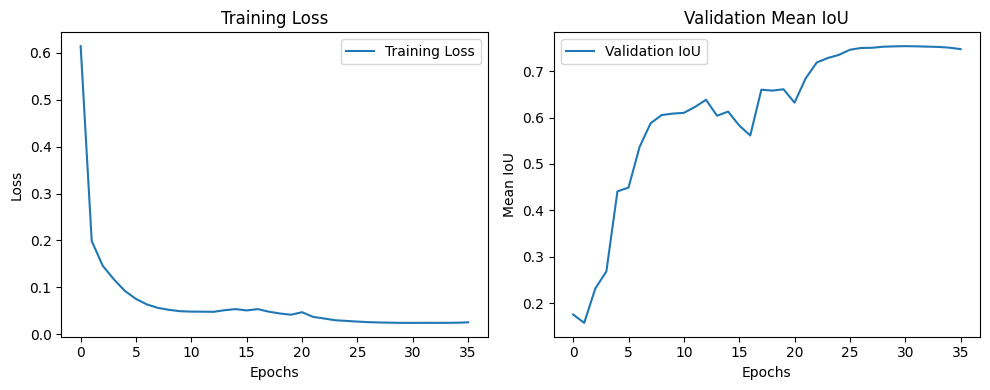


Evaluating on the validation set:


100%|██████████| 21/21 [00:06<00:00,  3.40it/s]

Validation Mean IoU: 0.7473
Validation Per-class IoU: {0: 0.9933674637966896, 1: 0.7276942508693448, 2: 0.7248914842573984, 3: 0.747335658023931, 4: 0.28732639687607014, 5: 0.924186560123542, 6: 0.8506261254425331, 7: 0.8185902830219588, 8: 0.6518494638731044}


In [2]:
import os
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt

# 设置随机种子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 定义数据集类
class FullDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=352, limit=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])[:limit]
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])[:limit]
        self.image_size = image_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        
        image = Image.open(image_path).convert('RGB').resize((self.image_size, self.image_size))
        mask = Image.open(mask_path).resize((self.image_size, self.image_size))

        image = np.array(image) / 255.0
        mask = np.array(mask)
        mask = np.clip(mask, 0, 8)   #发现有多于9个classes的mask,所以这里过滤掉
       
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.long)
        
        return {'image': image, 'label': mask}
        

# 定义模型
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class SAM2UNet(nn.Module):
    def __init__(self):
        super(SAM2UNet, self).__init__()
        self.encoder1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up1 = Up(1024 + 512, 512)
        self.up2 = Up(512 + 256, 256)
        self.up3 = Up(256 + 128, 128)
        self.up4 = Up(128 + 64, 64)
        self.head = nn.Conv2d(64, 9, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder1(x)
        x2 = self.encoder2(self.pool1(x1))
        x3 = self.encoder3(self.pool2(x2))
        x4 = self.encoder4(self.pool3(x3))
        x5 = self.bottleneck(self.pool4(x4))
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.head(x)

# 定义 IoU 计算函数
def calculate_iou(pred_mask, true_mask, num_classes):
    pred_mask = pred_mask.argmax(dim=1)
    iou_list = []
    per_class_iou = {}
    for i in range(num_classes):
        intersection = ((pred_mask == i) & (true_mask == i)).sum().item()
        union = ((pred_mask == i) | (true_mask == i)).sum().item()
        iou = intersection / union if union != 0 else float('nan')
        iou_list.append(iou)
        per_class_iou[i] = iou
    mean_iou = np.nanmean(iou_list)
    return mean_iou, per_class_iou

# 定义评估函数
def evaluate(model, dataloader, device, num_classes=9):
    model.eval()
    metric_list = []
    per_class_iou_total = {i: [] for i in range(num_classes)}
    with torch.no_grad():
        for data in tqdm(dataloader):
            images = data['image'].to(device)
            masks = data['label'].to(device)
            outputs = model(images)
            mean_iou, per_class_iou = calculate_iou(outputs, masks, num_classes)
            for class_id, iou in per_class_iou.items():
                if not np.isnan(iou):
                    per_class_iou_total[class_id].append(iou)
            metric_list.append(mean_iou)
    avg_per_class_iou = {class_id: np.nanmean(iou_list) for class_id, iou_list in per_class_iou_total.items()}
    mean_iou = np.mean(metric_list)
    return mean_iou, avg_per_class_iou


# Modify train_model function to include early stopping
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device, save_path="checkpoints", patience=5):
    os.makedirs(save_path, exist_ok=True)  # Create save directory
    
    best_val_iou = 0  # Track the best validation IoU
    epochs_no_improve = 0  # Count epochs with no improvement
    early_stop = False  # Flag for early stopping
    
    train_losses = []
    val_ious = []
    
    for epoch in range(num_epochs):
        if early_stop:
            print("Early stopping triggered.")
            break
        
        model.train()
        running_loss = 0.0
        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = data['image'].to(device)
            masks = data['label'].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

        # Validation evaluation
        model.eval()
        val_iou, val_per_class_iou = evaluate(model, val_loader, device)
        val_ious.append(val_iou)
        print(f"Validation Mean IoU: {val_iou:.4f}")
        print(f"Validation Per-class IoU: {val_per_class_iou}")

        # Early stopping check
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            epochs_no_improve = 0
            # Save the best model
            best_model_path = os.path.join(save_path, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved at epoch {epoch+1}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"No improvement for {patience} epochs. Stopping early.")
                early_stop = True

        # Save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(save_path, f"model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model saved at {checkpoint_path}")
    
    # Save final model weights
    final_model_path = os.path.join(save_path, "SAM2_UNet_final.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")
    
    # Plot training loss and validation IoU
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_ious, label="Validation IoU")
    plt.xlabel("Epochs")
    plt.ylabel("Mean IoU")
    plt.title("Validation Mean IoU")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 设置保存的路径（如果需要保存到特定位置）
save_directory = "Groupproject/SAM2_UNet_checkpoints"  # 自定义路径

# 创建模型实例并加载保存的权重
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SAM2UNet().to(device)

# Define the path to the saved model checkpoint
checkpoint_path = os.path.join(save_directory, "SAM2_UNet_final.pth")  # 使用已保存的checkpoint

# 加载模型权重，避免重新训练
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print("Model loaded from", checkpoint_path)
else:
    print("Checkpoint not found, training from scratch.")

# 创建数据加载器
train_dataset = FullDataset('Groupproject/train/images', 'Groupproject/train/masks')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = FullDataset('Groupproject/val/images', 'Groupproject/val/masks')
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 创建优化器和学习率调度器
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# 若需要继续训练
train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=60, device=device, save_path=save_directory)

# 或者只在验证集上进行评估
print("\nEvaluating on the validation set:")
val_iou, val_per_class_iou = evaluate(model, val_loader, device)
print(f"Validation Mean IoU: {val_iou:.4f}")
print(f"Validation Per-class IoU: {val_per_class_iou}")
